In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Generating Data

In [3]:
df=pd.read_csv("/content/drive/My Drive/6998/project/TSLA.csv")
# df = pd.read_csv('./tsla.us.txt')
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [4]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

In [5]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(5, 800):
    X_train.append(training_set_scaled[i-5:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

# Manual LSTM Model

In [6]:
model_LSTM = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_LSTM.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = 50, return_sequences = True))
model_LSTM.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = 50, return_sequences = True))
model_LSTM.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = 50))
model_LSTM.add(Dropout(0.2))
# Adding the output layer
model_LSTM.add(Dense(units = 1))

# Compiling the RNN
model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

import time
t1 = time.perf_counter()

# Fitting the RNN to the Training set
model_LSTM.fit(X_train, y_train, epochs = 100, batch_size = 32)

t2 = time.perf_counter()
time_taken = 'Time taken to run:' + str(t2-t1)
print(time_taken)

Epoch 1/100
25/25 [==============================] - 9s 8ms/step - loss: 0.1383
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 10/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 11/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 12/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 13/100
25/25 [=================

In [7]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 5:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

sc_test = MinMaxScaler(feature_range = (0, 1))
inputs_scaled = sc_test.fit_transform(inputs)

X_test = []
y_test = []

for i in range(5, 464):
    X_test.append(inputs[i-5:i, 0])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
t1 = time.perf_counter()
predicted_stock_price = model_LSTM.predict(X_test)
t2 = time.perf_counter()

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(model_LSTM.evaluate(X_test,y_test), t2-t1)

15/15 [==============================] - 1s 3ms/step - loss: 0.7528
0.7528371214866638 1.2876015710000956


In [9]:
!mkdir -p saved_model
model_LSTM.save('saved_model/manual_LSTM')

INFO:tensorflow:Assets written to: saved_model/manual_LSTM/assets


INFO:tensorflow:Assets written to: saved_model/manual_LSTM/assets


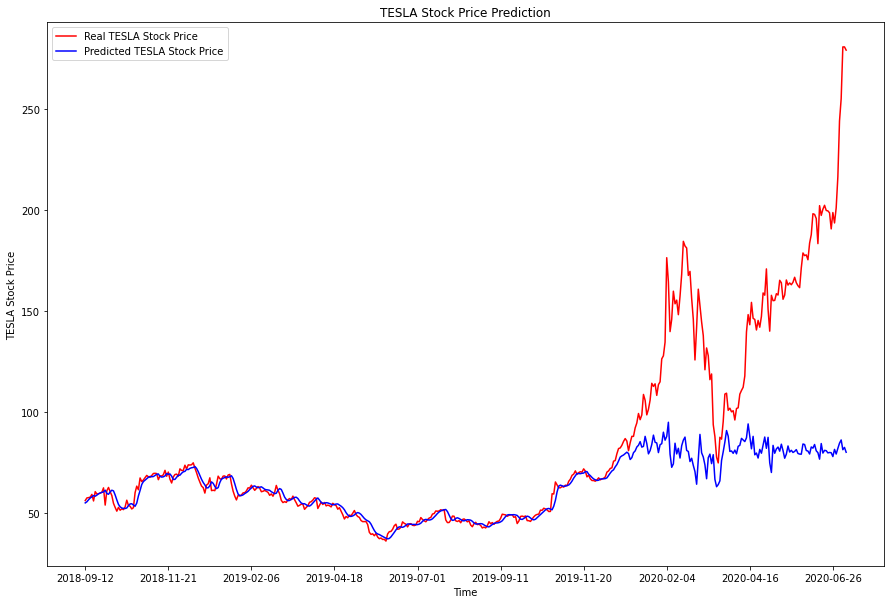

In [10]:
# Visualising the results
plt.rcParams["figure.figsize"]=(15,10)
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [13]:
acc_LSTM = 100 - (abs(predicted_stock_price - dataset_test.values) / dataset_test.values * 100).mean()

In [34]:
print(acc_LSTM)

85.8985318191656


## Results

Time taken to train: 27.95s

Loss: 0.7528

Accuracy: 85.90

# Manual GRU Model

In [14]:
model_GRU = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_GRU.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_GRU.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model_GRU.add(GRU(units = 50))
model_GRU.add(Dropout(0.2))
# Adding the output layer
model_GRU.add(Dense(units = 1))

# Compiling the RNN
model_GRU.compile(optimizer = 'adam', loss = 'mean_squared_error')

import time
t1 = time.perf_counter()

# Fitting the RNN to the Training set
model_GRU.fit(X_train, y_train, epochs = 100, batch_size = 32)

t2 = time.perf_counter()
time_taken = 'Time taken to run:' + str(t2-t1)
print(time_taken)

Epoch 1/100
25/25 [==============================] - 5s 7ms/step - loss: 0.0668
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0064
Epoch 11/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 12/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 13/100
25/25 [=================

In [15]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 5:].values
inputs = inputs.reshape(-1,1)
sc_test = MinMaxScaler(feature_range = (0, 1))
inputs = sc.transform(inputs)

X_test = []
y_test = []

for i in range(5, 464):
    X_test.append(inputs[i-5:i, 0])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
t1 = time.perf_counter()
predicted_stock_price = model_GRU.predict(X_test)
t2 = time.perf_counter()

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(model_GRU.evaluate(X_test,y_test), t2-t1)

15/15 [==============================] - 1s 3ms/step - loss: 0.0941
0.09409523755311966 1.364219028999969


In [17]:
!mkdir -p saved_model
model_GRU.save('saved_model/manual_GRU')

INFO:tensorflow:Assets written to: saved_model/manual_GRU/assets


INFO:tensorflow:Assets written to: saved_model/manual_GRU/assets


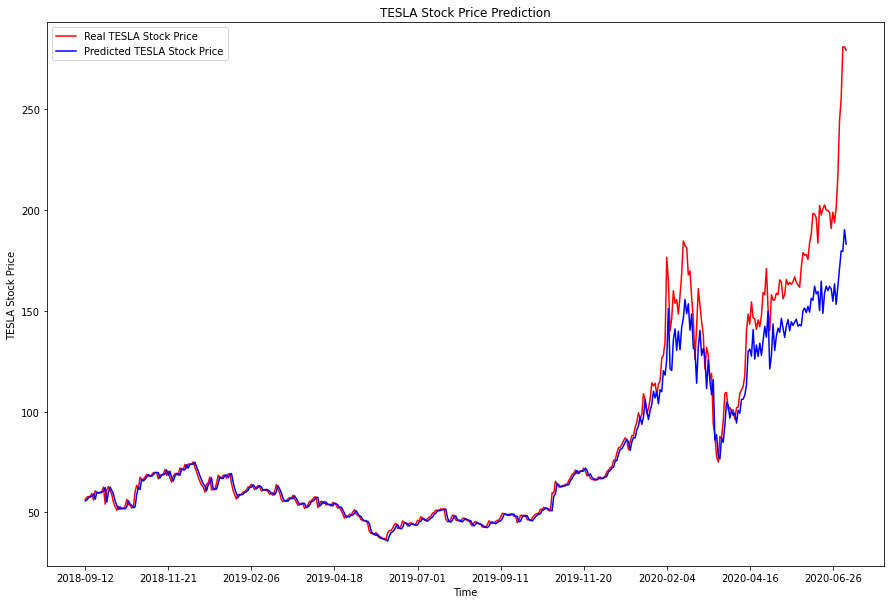

In [18]:
# Visualising the results
plt.rcParams["figure.figsize"]=(15,10)
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [19]:
acc_GRU = 100 - (abs(predicted_stock_price - dataset_test.values) / dataset_test.values * 100).mean()

In [35]:
print(acc_GRU)

94.7658690115122


## Results
Time taken to train: 22.70s

Loss: 0.0941

Accuracy: 94.77

# LSTM stacked NAS model

In [20]:
model_stack = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_stack.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_stack.add(Dropout(0.1))
model_stack.add(LSTM(units = 50))
model_stack.add(Dropout(0.2))
model_stack.add(Dense(units = 1))


# Compiling the RNN
model_stack.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_stack.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 3s 5ms/step - loss: 0.0883
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0068
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 11/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 12/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 13/100
25/25 [=================

In [26]:
t1 = time.perf_counter()
predicted_stock_price = model_stack.predict(X_test)
t2 = time.perf_counter()
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(model_stack.evaluate(X_test,y_test), t2-t1)

15/15 [==============================] - 1s 5ms/step - loss: 0.2545
0.2544763386249542 0.6441872210000383


In [22]:
!mkdir -p saved_model
model_stack.save('saved_model/LSTM_Stacked')

INFO:tensorflow:Assets written to: saved_model/LSTM_Stacked/assets


INFO:tensorflow:Assets written to: saved_model/LSTM_Stacked/assets


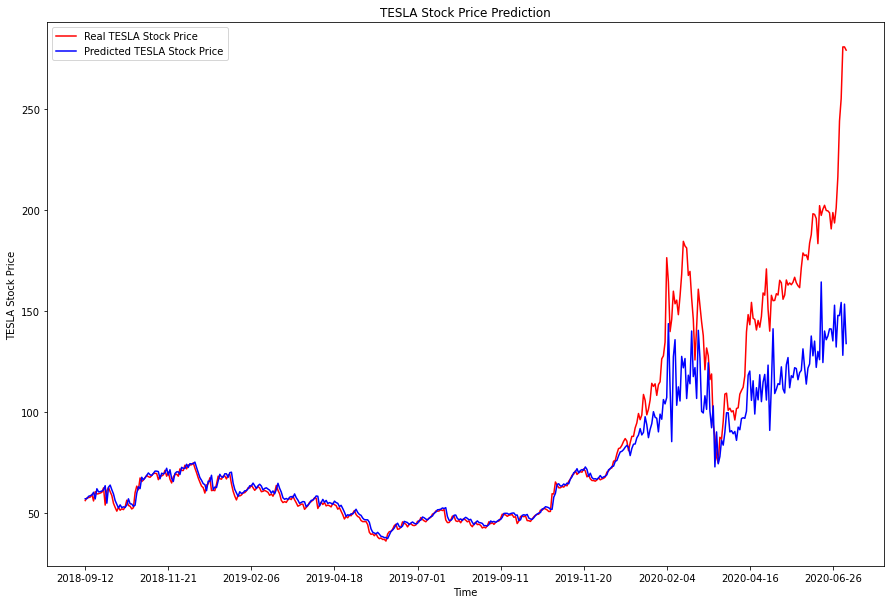

In [28]:
# Visualising the results
plt.rcParams["figure.figsize"]=(15,10)
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [24]:
acc_LSTM_st = 100 - (abs(predicted_stock_price - dataset_test.values) / dataset_test.values * 100).mean()

In [37]:
print(acc_LSTM_st)

91.5925141679735


## Results

Time taken to train: 15722.81s

Loss: 0.2544763386249542

Accuracy: 91.59

# Diverse Architectures NAS model

In [25]:
model_div = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_div.add(GRU(units = 40, return_sequences = True, activation="relu",
                         input_shape = (X_train.shape[1], 1)))
model_div.add(Dense(units = 20))
model_div.add(LSTM(units = 80, return_sequences = True, activation="relu"))
model_div.add(LSTM(units = 50))
model_div.add(Dense(units = 1))

# Compiling the RNN
model_div.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_div.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 4s 19ms/step - loss: 0.1382
Epoch 2/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0182
Epoch 3/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0053
Epoch 4/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0030
Epoch 5/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0028
Epoch 6/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0028
Epoch 7/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0030
Epoch 8/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0031
Epoch 9/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0029
Epoch 10/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0026
Epoch 11/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0026
Epoch 12/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0025
Epoch 13/100
25/25 [=====

In [21]:
t1 = time.perf_counter()
predicted_stock_price = model_div.predict(X_test)
t2 = time.perf_counter()

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(model_div.evaluate(X_test,y_test), t2-t1)

15/15 [==============================] - 1s 3ms/step - loss: 0.0585
0.05853773280978203 0.6690513359999386


In [27]:
!mkdir -p saved_model
model_div.save('saved_model/Diverse_NAS')

INFO:tensorflow:Assets written to: saved_model/Diverse_NAS/assets


INFO:tensorflow:Assets written to: saved_model/Diverse_NAS/assets


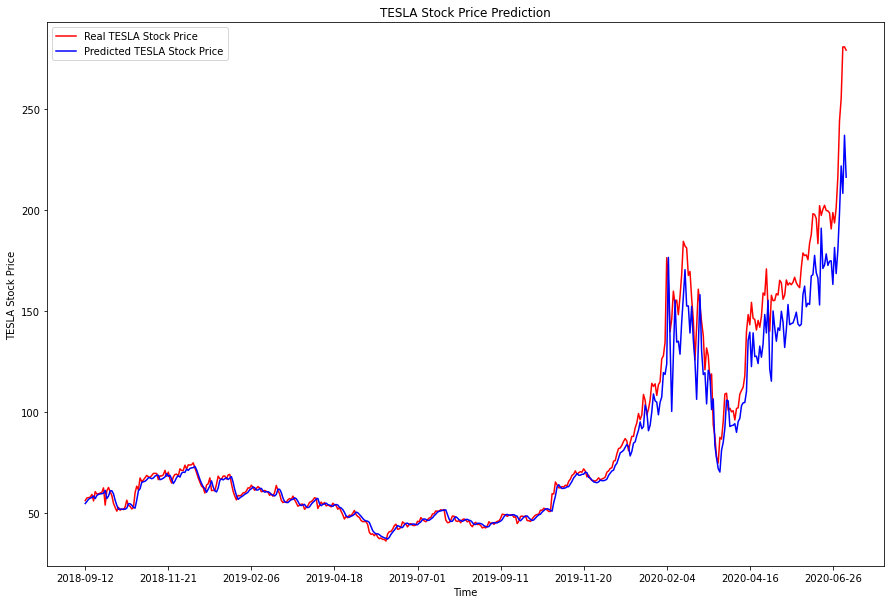

In [23]:
# Visualising the results
plt.rcParams["figure.figsize"]=(15,10)
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [29]:
acc_div = 100 - (abs(predicted_stock_price - dataset_test.values) / dataset_test.values * 100).mean()

In [36]:
print(acc_div)

94.829992410144


## Results

Time taken to train: 32505.52s

Loss: 0.0585

Accuracy: 94.83

# Experiments

## EXP 1: Accuracy

In [38]:
print("Accuracy of Manual LSTM Model: " + str(acc_LSTM))
print("Accuracy of Manual GRU Model: " + str(acc_GRU))
print("Accuracy of Stacked NAS Model: " + str(acc_LSTM_st))
print("Accuracy of Diverse NAS Model: " + str(acc_div))

Accuracy of Manual LSTM Model: 85.8985318191656
Accuracy of Manual GRU Model: 94.7658690115122
Accuracy of Stacked NAS Model: 91.5925141679735
Accuracy of Diverse NAS Model: 94.829992410144


## EXP 2: Transferability

In [31]:
def calculate_ev_time_acc(model, dataset):
  df=pd.read_csv(dataset)
  # df = pd.read_csv('./tsla.us.txt')
  print("Number of rows and columns:", df.shape)
  df.head(5)

  training_set = df.iloc[:800, 1:2].values
  test_set = df.iloc[800:, 1:2].values

  # Feature Scaling
  sc = MinMaxScaler(feature_range = (0, 1))
  training_set_scaled = sc.fit_transform(training_set)
  # Creating a data structure with 60 time-steps and 1 output
  X_train = []
  y_train = []
  for i in range(5, 800):
      X_train.append(training_set_scaled[i-5:i, 0])
      y_train.append(training_set_scaled[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  #(740, 60, 1)

  # Getting the predicted stock price of 2017
  dataset_train = df.iloc[:800, 1:2]
  dataset_test = df.iloc[800:, 1:2]
  dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
  inputs = dataset_total[len(dataset_total) - len(dataset_test) - 5:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)

  sc_test = MinMaxScaler(feature_range = (0, 1))
  inputs_scaled = sc_test.fit_transform(inputs)

  X_test = []
  y_test = []

  for i in range(5, 464):
      X_test.append(inputs[i-5:i, 0])
      y_test.append(inputs[i, 0])

  X_test, y_test = np.array(X_test), np.array(y_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  t1 = time.perf_counter()
  predicted_stock_price = model.predict(X_test)
  t2 = time.perf_counter()
  predicted_stock_price = sc.inverse_transform(predicted_stock_price)

  model.evaluate(X_test,y_test)
  acc = 100 - (abs(predicted_stock_price - dataset_test.values) / dataset_test.values * 100).mean()
  
  return t2-t1, acc

In [32]:
import time

eva_times = []
accs = []

datasets = ["/content/drive/My Drive/6998/project/GOOG.csv", "/content/drive/My Drive/6998/project/AAPL.csv", "/content/drive/My Drive/6998/project/MSFT.csv"]

for d in datasets:
  print(d)
  e,a = calculate_ev_time_acc(model_LSTM, d)
  eva_times.append(e)
  accs.append(a)

  e,a = calculate_ev_time_acc(model_GRU, d)
  eva_times.append(e)
  accs.append(a)

  e,a = calculate_ev_time_acc(model_stack, d)
  eva_times.append(e)
  accs.append(a)

  e,a = calculate_ev_time_acc(model_div, d)
  eva_times.append(e)
  accs.append(a)

/content/drive/My Drive/6998/project/GOOG.csv
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 3ms/step - loss: 0.9274
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 3ms/step - loss: 0.0525
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 3ms/step - loss: 0.0530
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 4ms/step - loss: 0.2758
/content/drive/My Drive/6998/project/AAPL.csv
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 3ms/step - loss: 0.0015
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 3ms/step - loss: 4.5280e-04
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 3ms/step - loss: 5.3466e-04
Number of rows and columns: (1259, 7)
15/15 [==============================] - 0s 4ms/step - loss: 9.9214e-04
/content/drive/My Drive/6998/project/MSFT.csv
Nu

In [43]:
i = 0
mean_ev = (eva_times[i] + eva_times[i+4] + eva_times[i+8] + 1.2876015710000956) / 4
mean_acc = (accs[i] + accs[i+4] + accs[i+8] + acc_LSTM) / 4
print("Manual LSTM mean time taken to evaluate: " + str(mean_ev) + " seconds")
print("Manual LSTM mean accuracy on test set: " + str(mean_acc) + "%")

Manual LSTM mean time taken to evaluate: 0.3831309012500128 seconds
Manual LSTM mean accuracy on test set: 86.57511450801842%
79.91692629392361


In [44]:
i = 1
mean_ev = (eva_times[i] + eva_times[i+4] + eva_times[i+8] + 1.364219028999969) / 4
mean_acc = (accs[i] + accs[i+4] + accs[i+8] + acc_GRU) / 4
print("Manual GRU mean time taken to evaluate: " + str(mean_ev) + " seconds")
print("Manual GRU mean accuracy on test set: " + str(mean_acc) + "%")

Manual GRU mean time taken to evaluate: 0.4008286077499861 seconds
Manual GRU mean accuracy on test set: 95.76400768275064%


In [46]:
i = 2
mean_ev = (eva_times[i] + eva_times[i+4] + eva_times[i+8] + 0.6441872210000383) / 4
mean_acc = (accs[i] + accs[i+4] + accs[i+8] + acc_LSTM_st) / 4
print("LSTM stacked mean time taken to evaluate: " + str(mean_ev) + " seconds")
print("LSTM stacked mean accuracy on test set: " + str(mean_acc) + "%")

LSTM stacked mean time taken to evaluate: 0.21203359575002878 seconds
LSTM stacked mean accuracy on test set: 94.34359427034858%


In [47]:
i = 3
mean_ev = (eva_times[i] + eva_times[i+4] + eva_times[i+8] + 0.6690513359999386) / 4
mean_acc = (accs[i] + accs[i+4] + accs[i+8] + acc_div) / 4
print("Diverse NAS mean time taken to evaluate: " + str(mean_ev) + " seconds")
print("Diverse NAS mean accuracy on test set: " + str(mean_acc) + "%")

Diverse NAS mean time taken to evaluate: 0.23810147499995082 seconds
Diverse NAS mean accuracy on test set: 91.95918415682274%
